In [2]:
!pip install d2l==0.14.4

     |████████████████████████████████| 61kB 1.8MB/s 


loss 0.303, train acc 0.886, test acc 0.869
706.0 examples/sec on /CPU:0


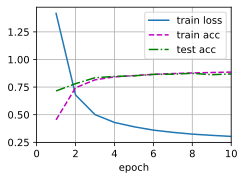

In [7]:
from d2l import tensorflow as d2l
import keras
import tensorflow as tf
from tensorflow.distribute import MirroredStrategy, OneDeviceStrategy
import matplotlib as plt
def net():
    return tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(filters=7, kernel_size=10, activation='relu',
                               padding='same'),
        tf.keras.layers.MaxPool2D(pool_size=2, strides=2),
        tf.keras.layers.Conv2D(filters=18, kernel_size=5,
                               activation='relu'),
        tf.keras.layers.MaxPool2D(pool_size=2, strides=2),
        tf.keras.layers.Conv2D(filters=25, kernel_size=4,
                               activation='relu'),
        tf.keras.layers.MaxPool2D(pool_size=2, strides=2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(120, activation='sigmoid'),
        tf.keras.layers.Dense(84, activation='sigmoid'),
        tf.keras.layers.Dense(10)])

X = tf.random.uniform((1, 28, 28, 1))
for layer in net().layers:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape: \t', X.shape)


batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)
class TrainCallback(tf.keras.callbacks.Callback):  #@save
    def __init__(self, net, train_iter, test_iter, num_epochs, device_name):
        self.timer = d2l.Timer()
        self.animator = d2l.Animator(
            xlabel='epoch', xlim=[0, num_epochs], legend=[
                'train loss', 'train acc', 'test acc'])
        self.net = net
        self.train_iter = train_iter
        self.test_iter = test_iter
        self.num_epochs = num_epochs
        self.device_name = device_name
    def on_epoch_begin(self, epoch, logs=None):
        self.timer.start()
    def on_epoch_end(self, epoch, logs):
        self.timer.stop()
        test_acc = self.net.evaluate(
            self.test_iter, verbose=0, return_dict=True)['accuracy']
        metrics = (logs['loss'], logs['accuracy'], test_acc)
        self.animator.add(epoch+1, metrics)
        if epoch == self.num_epochs - 1:
            batch_size = next(iter(self.train_iter))[0].shape[0]
            num_examples = batch_size * tf.data.experimental.cardinality(
                self.train_iter).numpy()
            print(f'loss {metrics[0]:.3f}, train acc {metrics[1]:.3f}, '
                  f'test acc {metrics[2]:.3f}')
            print(f'{num_examples / self.timer.avg():.1f} examples/sec on '
                  f'{str(self.device_name)}')

def train(net_fn, train_iter, test_iter, num_epochs, lr,
              device=d2l.try_gpu()):
    device_name = device._device_name
    strategy = tf.distribute.OneDeviceStrategy(device_name)
    with strategy.scope():
        optimizer = tf.keras.optimizers.SGD(learning_rate=lr)
        loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
        net = net_fn()
        net.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    callback = TrainCallback(net, train_iter, test_iter, num_epochs,
                             device_name)
    net.fit(train_iter, epochs=num_epochs, verbose=0, callbacks=[callback])
    return net
lr, num_epochs = 0.9, 10
train(net, train_iter, test_iter, num_epochs, lr)